Model Accuracy: 99.68%


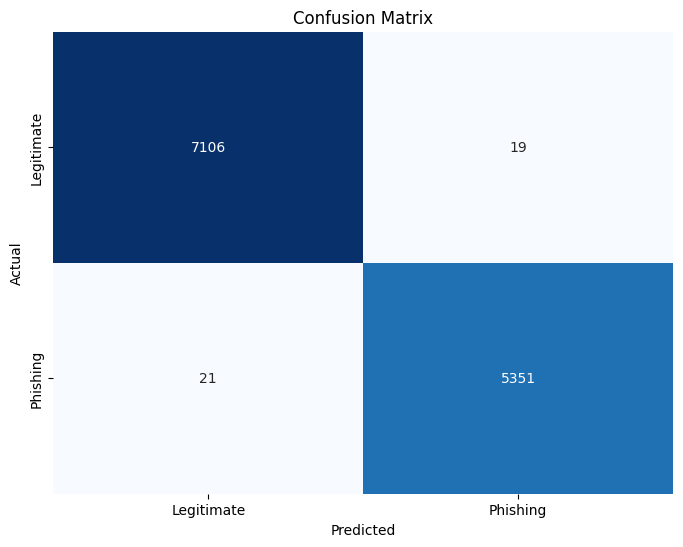


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7125
           1       1.00      1.00      1.00      5372

    accuracy                           1.00     12497
   macro avg       1.00      1.00      1.00     12497
weighted avg       1.00      1.00      1.00     12497



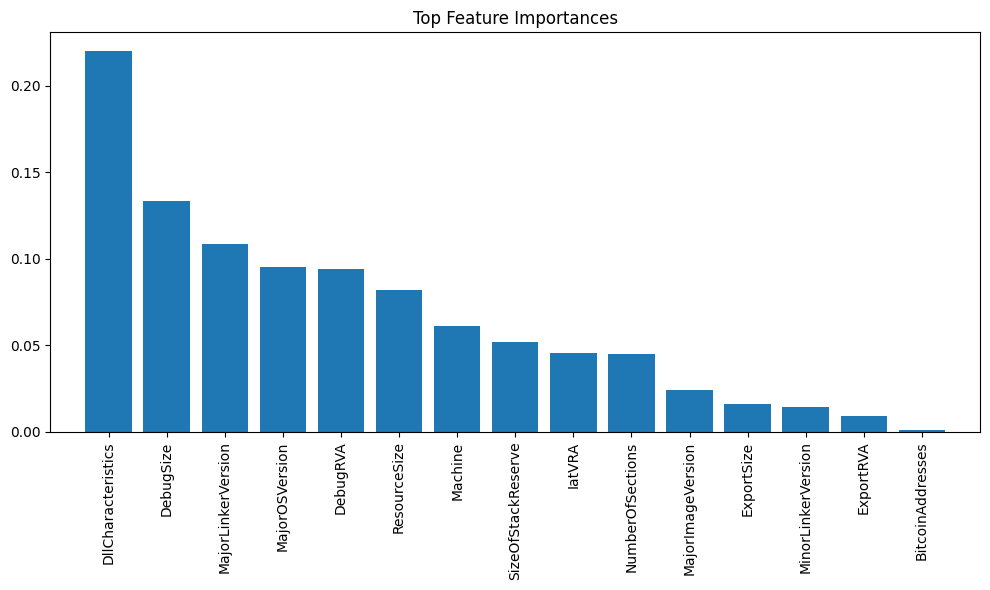

Top 15 features saved to top_features.txt


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pickle

# Load the dataset
data = pd.read_csv("../datasets/ransomware.csv")

# Drop the specified columns
data = data.drop(columns=['FileName', 'md5Hash'])

# Save the cleaned dataset as df_clear
data.to_csv("../datasets/df_clear.csv", index=False)

# Separating features and labels
X = data.iloc[:, :-1].values  # All rows, all columns except the last (label)
y = data.iloc[:, -1].values    # All rows, last column (label)
feature_names = data.columns[:-1]  # Column names except the last column

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Save the best model to a .pkl file
with open("rf_ransomware.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file)

# Evaluate model accuracy
score = best_model.score(X_test, y_test)
print(f"Model Accuracy: {score * 100:.2f}%")
print("Best parameters found: ", grid_search.best_params_)

# Make predictions and plot confusion matrix
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Legitimate', 'Ransomware'],
            yticklabels=['Legitimate', 'Ransomware'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort features by importance

# Plot feature importances with feature names
plt.figure(figsize=(10, 6))
plt.title("Top Feature Importances")
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), feature_names[indices], rotation=90)
plt.xlim([-1, len(feature_names)])
plt.tight_layout()
plt.show()

# Load the cleaned dataset and model
data = pd.read_csv("../datasets/df_clear.csv")
with open("rf_ransomware.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

# Get feature importances
importances = loaded_model.feature_importances_
feature_names = data.columns[:-1]  # Exclude the label column
indices = np.argsort(importances)[::-1]  # Sort by importance

# Save the top N features (e.g., top 111) to a .txt file
top_n = 15
top_features = feature_names[indices[:top_n]]
with open("top_features.txt", "w") as f:
    for feature in top_features:
        f.write(f"{feature}\n")

print(f"Top {top_n} features saved to top_features.txt")
